In [1]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
device = get_device()

'''
3-letter classification dataset (permuted without repetition)

in total, 6 classes

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'three_permuted_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
Initializing GPU cache for 2400 samples...
Cache initialized in 0.31 seconds
Initializing GPU cache for 600 samples...
Cache initialized in 0.01 seconds
num timesteps per sample: 48


In [4]:
num_h = 16

time_window = 48

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)


snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=16, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=16, out_features=16, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=16, out_features=6, bias=False)
    )
  )
)

In [5]:
ckpt_dir = 'permuted_3letters_task_H16'
num_epochs = 50

lr_tau = 0.1


train(snn_vf, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_f, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Epoch [1/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 6.79299
Step [12/18], Loss: 4.80875
Step [18/18], Loss: 2.61807
Time elasped: 2.610607147216797
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 2.06257
Step [12/18], Loss: 1.92174
Step [18/18], Loss: 1.80461
Time elasped: 2.5797526836395264
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.84851
Step [12/18], Loss: 1.83938
Step [18/18], Loss: 1.81699
Time elasped: 2.5354928970336914
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.83398
Step [12/18], Loss: 1.85095
Step [18/18], Loss: 1.83464
Time elasped: 2.5643484592437744
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [6/18], Loss: 1.81706
Step [12/18], Loss: 1.79678
Step [18/18], Loss: 1.84961
Time elasped: 2.8590288162231445
600
Test Loss: 1.7967865943908692
Avg spk_count per neuron for all 48 time-steps 17.500833333333333
Test Accuracy of the model on the test samples: 18.167

max acc: 18.1666666666666

Text(0.5, 1.0, 'train loss')

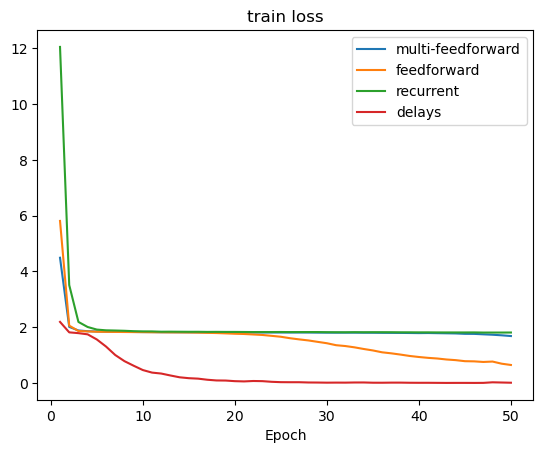

In [6]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

Text(0.5, 1.0, 'test loss')

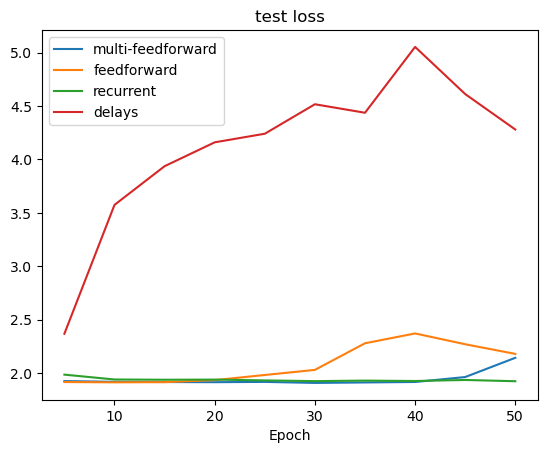

In [8]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.test_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.test_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.test_loss, label = 'recurrent')
plot_per_epoch(snn_rd.test_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('test loss')

In [9]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()


# from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
# images, labels_mf = propagate_batch_simple(snn_f, test_loader)
# _, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
# _, labels_rd = propagate_batch_simple(snn_rd, test_loader)

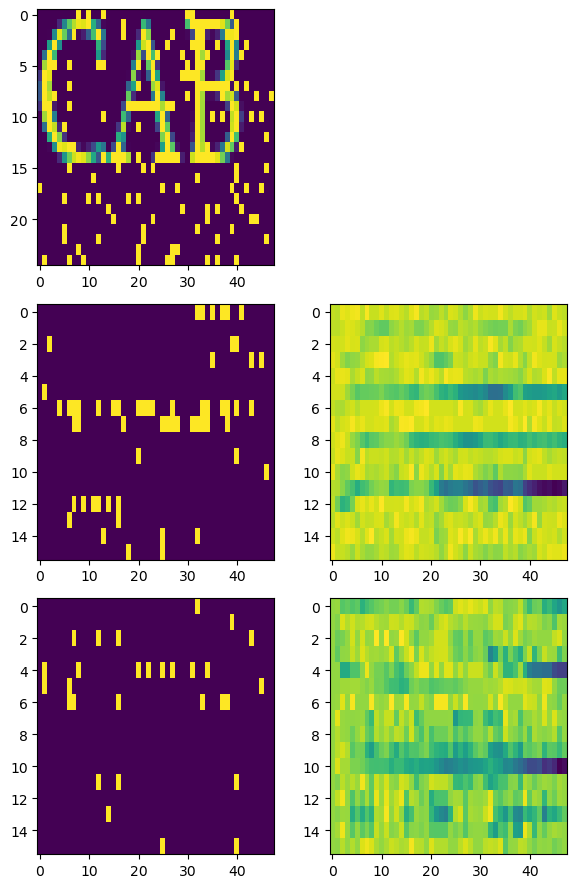

In [10]:
images, _ = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

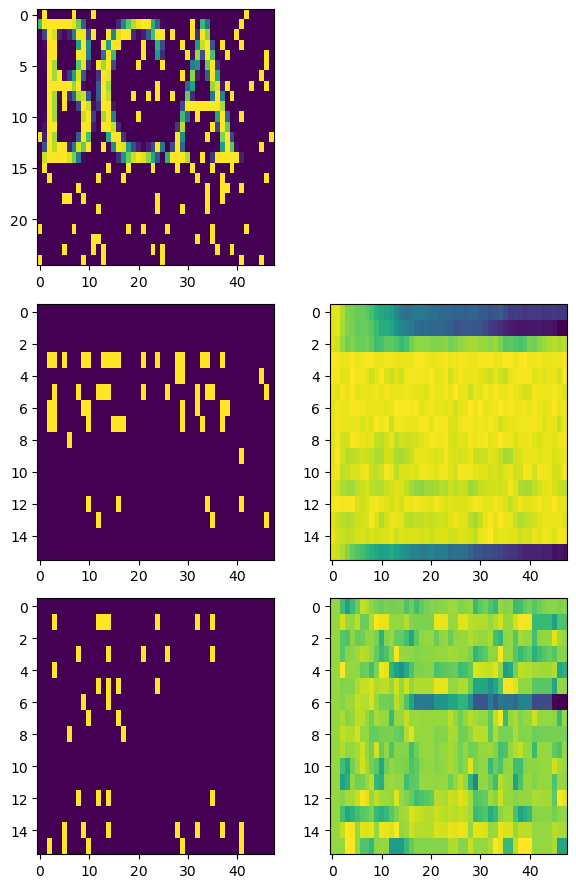

In [11]:
images, _ = propagate_batch_simple(snn_vf, test_loader)
spk = snn_vf.spike_state
mem = snn_vf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

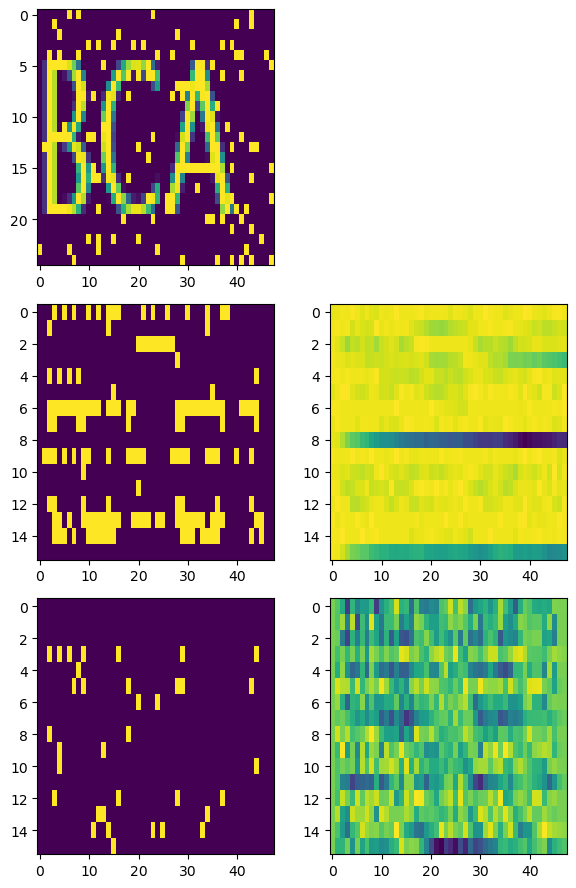

In [12]:
images, _ = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

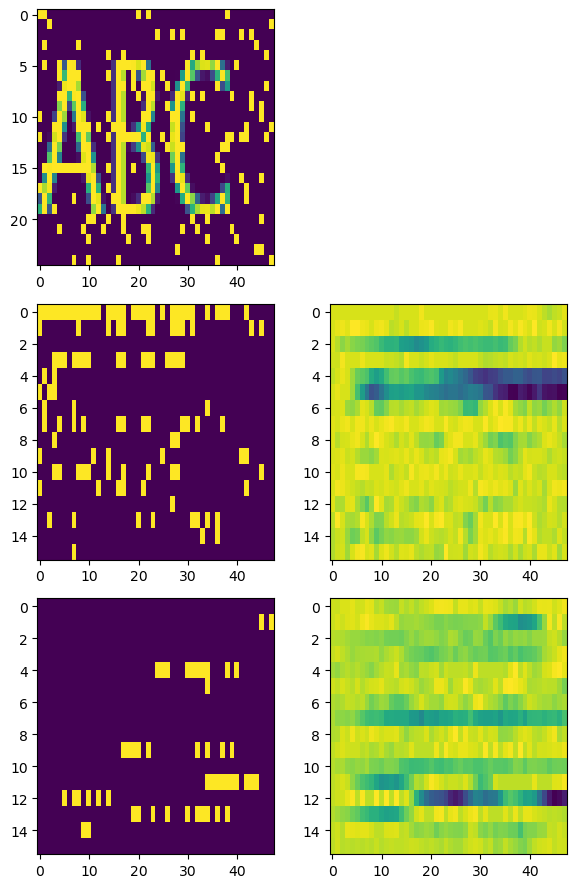

In [14]:
images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

In [15]:
ckpt_dir = 'permuted_3letters_task_H16'
snn_f.save_model('snn_mf', ckpt_dir)
snn_rnn.save_model('snn_rnn', ckpt_dir)
snn_rd.save_model('snn_rd', ckpt_dir)
snn_vf.save_model('snn_f', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_3letters_task_H16


In [18]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'permuted_3letters_task_H16'
snn_vf = ModelLoader('snn_f', ckpt_dir, 128, 'cuda')
snn_mf = ModelLoader('snn_mf', ckpt_dir, 128, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 128, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 128, 'cuda')

Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Delta t: 20.833333333333332 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [19]:
a, b = snn_vf.test(test_loader)
a, b = snn_mf.test(test_loader)
a, b = snn_rnn.test(test_loader)
a, b = snn_rd.test(test_loader)

600
Test Loss: 2.0297927141189573
Avg spk_count per neuron for all 48 time-steps 42.7925
Test Accuracy of the model on the test samples: 40.833

600
Test Loss: 2.0066000699996946
Avg spk_count per neuron for all 48 time-steps 39.681666666666665
Test Accuracy of the model on the test samples: 20.833

600
Test Loss: 1.8031347513198852
Avg spk_count per neuron for all 48 time-steps 88.06333333333333
Test Accuracy of the model on the test samples: 18.167

600
Test Loss: 4.028201866149902
Avg spk_count per neuron for all 48 time-steps 76.49166666666666
Test Accuracy of the model on the test samples: 55.667

